In [1]:
# For Python 3

from importlib import reload
import numpy as np
import data
reload(data)
import momentum
reload(momentum)
import trading
reload(trading)

from keras.models import Sequential, model_from_json
from keras.layers import Dense, Activation, Dropout
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
'''
start="01/01/2010 06:00:00"
end="31/12/2010 13:59:21"
X = data.loadData("data/SPX_2010.h5", start, end)

'''
start="01/01/2012 06:00:00"
end="31/12/2012 13:59:21"
X1 =data.loadData("data/SPX_2012.h5", start, end)
start="01/01/2013 06:00:00"
end="31/12/2013 13:59:21"
X2 =data.loadData("data/SPX_2013.h5", start, end)
start="01/01/2014 06:00:00"
end="31/12/2014 13:59:21"
X3 =data.loadData("data/SPX_2014.h5", start, end)

X = np.concatenate([X1, X2, X3])

Loading data...
Done.
Loading data...
Done.
Loading data...
Done.


In [3]:
PAST, FUTURE = 1/24., 1/24.

dataset = trading.build_trading_windows(X, PAST, FUTURE)
ts, os = data.build_train_test(X1, PAST, FUTURE, training_size=0.)
ts_X, ts_Y = np.array([sample[0] for sample in ts]), np.array([sample[1] for sample in ts])
os_X, os_Y = np.array([sample[0] for sample in os]), np.array([sample[1] for sample in os])

HBox(children=(IntProgress(value=0, max=1804), HTML(value='')))

HBox(children=(IntProgress(value=0, max=742), HTML(value='')))

HBox(children=(IntProgress(value=0, max=742), HTML(value='')))

In [4]:
json_file = open('trained/saved_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("trained/saved_model.h5")
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [5]:
signatures = np.array([sample[0] for sample in dataset])
predictions_momentum = model.predict(signatures).flatten()
real = list(map(momentum.hasMomentum, np.array(dataset)[:, 1]))
real = np.array(list(map(int, real)))
for i in range(len(dataset)):
    dataset[i] = list(dataset[i])
    dataset[i].append(predictions_momentum[i])
    

In [57]:
# Now we trade

money = [[dataset[0][1][0][0], 1000., 0.]]
for signature, window, prediction in dataset:
    len_window = len(window)
    #idx = int(len_window*0.7)
    idx = int(len_window*0.75)
    
    window_first = window[:idx]
    window_last = window[idx:]
    
    timestamp = window_last[-1][0]
    current_money = money[-1][1]
    
    THRESHOLD = 0.65
    if prediction<THRESHOLD:
        #money.append([timestamp, current_money, 0.])
        continue

    
    qv = momentum.quadraticVariation(window_first)
    squared_diff = (window_first[-1][1] - window_first[0][1])**2
    if qv < squared_diff:
        # We predict momentum, and we observe momentum - nothing to do here
        continue
    # Now, we've predicted momentum, but we observe mean reversion. We act.
    if window_first[-1][1] > window_first[0][1]:
        # Price going up - we buy
        position = 1.
    else:
        # Price going down - we short sell
        position = -1.
    
    current_price, last_price = window_last[0][1], window_last[-1][1]
    
    expected_win = np.sqrt(qv) + position*(window_first[0][1] - window_first[-1][1])
    #expected_win /= current_price
    f = (prediction * expected_win - (1-prediction)*abs(window_first[-1][1] - window_first[0][1] - expected_win))/expected_win
    print(f)
    
    
    money_to_invest = current_money*max(0, f)# * prediction
    shares = money_to_invest / current_price
    current_money -= position*money_to_invest
    last_money = last_price * shares
    current_money += position * last_money
    
    money.append([timestamp, current_money, position])
    

1.0
0.295585435992
-0.369839851428
0.677507908975
0.972794776344
-0.027707835046
0.100335130334
0.981999921272
0.919307482721
0.990525019909
0.997548084767
0.990633294047
0.534794944088
-0.0255067705515
0.667809629297
0.953445299601
0.906445047062
0.366001968592
0.0586984227925
0.348973150836
0.6031263434
0.998826963773
0.895762473468
0.324466259348
0.99854744827
-0.450168381742
0.711336403209
0.52012483014
1.0
0.990903989378
1.0
-0.0728250900555
0.99899485356
0.997980669059
-0.000914059565019
0.600945109391
0.96048722546
0.836562558515
-0.0189823191181
-3.83784241105
0.155201617078
0.623320279627
0.646954742876
0.926128014957
0.919399658657
0.999999471289
0.691293923759
1.0
-0.501459200621
0.721987224773
0.999998378846
0.611198009227
0.782236695567
-0.0376961547528
0.947201823773
0.558310240607
0.537914364804
0.260317050646
0.24107443671
0.999998853227
0.6148151295
-94.5871842828
0.695264740776
0.543194235353
0.970555970053
-0.085804041554
0.561436496454
0.815667787327
0.999394035562


In [58]:
sp500_0 = dataset[0][1][0][1]
sp500 = [[window[0][0], 1000*window[0][1]/sp500_0] for _, window, _ in dataset]

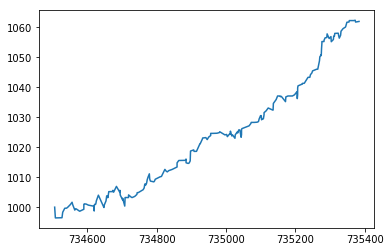

In [59]:
data.plot(money)

In [60]:
trading.statistics(money)

Statistics of the strategy
--------------------------

> Sharpe ratio: 4.7596746309
> Annual returns: 6.6%
> Max drawdown: -0.65%
> Positions
	Long: 52.89%
	Short: 46.67%
	Nothing: 0.44%


In [10]:
1-np.abs(real-list(map(round, predictions_momentum))).sum()/real.shape[0]

0.85088691796008864